# Reproducing Roeth and Tarantola using Modern Tools
## Part 1: Data Generation using Pytorch Distributions

In this first blog post series we'll be looking at reproducing and extending the seminal work by [Roeth and Tarantola](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB01563) on solving ill-posed inverse problems using neural networks. Sadly, their publication isn't available in the open domain. 

### What's it all about
The basic premise is that we wish to obtain the p-wave velocities of a layered earth model based on acoustic recordings obtained from seismic acquisition. Roeth and Tarantola work with synthetic data and generate 450 synthetic earth models at random based on the following paragraph:

```We generate a large number of Earth models, all with eight flat layers over a half-space. All layers have 200 m of thickness. The velocity of the first layer is generated pseudorandomly with a velocity of 1500 [m/s] _/- 150 [m/s] (box-car distribution). Once the velocity v of the l-th layer is given, the velocity v(l+1) in the l-th layer is generated psedourandomly as``` 

$$v_{l+1} = (v_{l} + 190 \ [\frac{m}{s}]) \pm 380 \ [\frac{m}{s}]$$ 

```where, again, the plus or minus sign refers to a box-car distribution. This yields an average increase of velocity of 190 [m/s] per layer but allows local negative velocity jumps. This rule takes into account that in general velocity increases with depth but locally there might exist low-velocity zones. In all our velocity plots, the velocity is normalized with respect to a maximal value of 4000 [m/s]. This normalization is necessary as the choice of the sigmoidal output function only permits values between zero and one.```

### What we're going to do

So here's what we're going to do in this series of blog posts:

- Part 1 (this post): Implement a basic generative model based on the above description by Roeth and Tarantola
- Part 2: Create synthetic training and test sets of acoustic waveforms using devito to try based on the generative model defined by the authors and implemented in part 1.
- Part 3: Recreate the neural network architecture proposed by Roeth and Tarantola to solve the inverse problem.
- Part 4: Where do we go from here: 19994-2019 Neural Networks and Inversion

Now comes the best part: I'll try and make all of this possible with open tools.   
To be fair the most closed puzzle piece I have found up to now is the [publication](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/93JB01563) itself!

### Getting started

To follow along you will need a current version of [Pytorch](https://www.pytorch.org) installed.  
I personally recommend version 1.0, as this features the most complete and stable version of the pytorch API.

Besides that a basic [anaconda](https://anaconda.com) with python 3.6, [matplotlib](https://matplotlib.org) and Numpy are needed. 

### Importing the libraries and helper functions

Here we import some basic libraries including the pylab stack (numpy, matplotlib, etc) as well as [torch](www.pytorch.org) and some helper functions I put in [utils.py](utils.py) to plot the data we are generating. I also like to use the autoreload plugin when I'm working with external ```.py``` files just so I don't have to ```Restart Kernel->Run All``` everytime I make a small change outside of jupyter notebooks.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import torch
from utils import plot_velocity_profile_grid

Populating the interactive namespace from numpy and matplotlib


### What are Pytorch Distributions

So what are Pytorch Distributions?   
They are very similar to numpy's ```numpy.random``` suite of random number generators with a number of 
additional bells and whistles for random samplers used in the framework of stochastic optimization and machine learning.
So why don't we use numpy's own random number generators?  
That's a good question, up to now there's three reasons I've found:

- Fast random number generation on GPU
- Algorithmic possibilities e.g. score functions for REINFORCE and pathwise derivatives such as the reparametrization trick used in Variational Autoencoders. [More here by the Pytorch Devs](https://pytorch.org/docs/stable/distributions.html)
- Having a computational graph including random generators fully defined within the torch environment opens up a path to probabilistic programming via [Pyro](https://www.pyro.ai). More on pyro in a later post.


The basic use is very simple:

We define a parametric distribution we wish to sample from simply by instantiating a ```distribution``` object.

In [2]:
a_uniform_distribution = torch.distributions.Uniform(low=0, high=1)
print(a_uniform_distribution)

Uniform(low: 0.0, high: 1.0)


This does not yet sample numbers for us, but we can easily do so by calling ```.sample()``` on our newly created instance of a uniform distribution (box-car distribution).

In [3]:
print(a_uniform_distribution.sample())
print(a_uniform_distribution.sample((100, 100)))
print("Just the number itself: ", a_uniform_distribution.sample().item())

tensor(0.9912)
tensor([[0.2360, 0.3550, 0.5608,  ..., 0.5266, 0.5391, 0.6076],
        [0.0730, 0.8575, 0.6469,  ..., 0.6756, 0.7055, 0.3827],
        [0.4565, 0.8585, 0.4145,  ..., 0.9342, 0.7287, 0.9118],
        ...,
        [0.3652, 0.8755, 0.8293,  ..., 0.0026, 0.8011, 0.5471],
        [0.1129, 0.3301, 0.7413,  ..., 0.5242, 0.6904, 0.3652],
        [0.4160, 0.9562, 0.1244,  ..., 0.6758, 0.9105, 0.4020]])
Just the number itself:  0.5304840803146362


You can see we can either just get a single number as a Tensor or we can also specify that we wish to sample Tensors of random numbers from this distribution. Having learned some basics of how to use distributions we can now define the generative model proposed by Roeth and Tarantola.

## The Generative Earth Model

We want our earth to have 9 layers:
- The first layer has a velocity of $v_0=1500 \pm 150 [\frac{m}{s}]$.
- Subsequent velocities of the layers will have $v_{l+1} = (v_{l} + 190 \ [\frac{m}{s}]) \pm 380 \ [\frac{m}{s}]$
- The maximum velocity should be 4000 $[\frac{m}{s}]$
- All layers have 200 $[m]$ of thickness, so a total thickness of 1800 $[m]$.
- From later in the paper we know the domain should be 2500 $[m]$ wide.
- We choose a grid-block spacing of 5 $[m]$ to discretize our model in y (horizontal) and z (vertical) directions.
- This also means that a single layer consists of 40 grid-blocks i.e. $40 \ [block] * 5 \ [\frac{m}{block}]=200  [m]$ thickness.

In [4]:
dx = 5.0
dz = 40
nz = 360
ny = 500

v0 = 1500
v_max = 4000
dv_l_const = 190.
n_layers = 9

### Defining the probability distributions

Based on the above description we'll need two sampling distributions one for the initial velocity ($\pm 150 \ [\frac{m}{s}]$)  
and a second one for the subsequent layers ($\pm380 \ [\frac{m}{s}]$). We also set the random number generators so we create the same output every time we run the notebook (for science! and reproducibility).
Random seed chosen for reasons provided in [Adams 1978](https://en.wikipedia.org/wiki/The_Hitchhiker%27s_Guide_to_the_Galaxy)

In [5]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

dVel0 = torch.distributions.Uniform(low=-150, high=150)
dVel =  torch.distributions.Uniform(low=-380, high=380)

We'll now need to create a basic container for our random model and sample the velocity of our initial layer:

In [6]:
model = torch.ones(nz, ny)

vl = v0+dVel0.sample()
print(vl.item())

1614.6807861328125


With this initial velocity defined we can now iterate over the ```n_layers``` in our model and sample at random the subsequent velocities. But careful if we exceed the 4000 $[\frac{m}{s}]$ we'll need to cap off there so we need an if clause to check that:

In [7]:
for i in range(0, n_layers):
    model[dz*i:dz*(i+1), :] = vl
    vl =(vl+dv_l_const)+dVel.sample()
    if vl >= v_max:
        vl = torch.ones(1)*v_max
        vl = vl[0]
    print("Layer ", i+1, " at depth ", dz*i*dx, "[m] to ", dz*(i+1)*dx, "[m] has velocity of %3.1f" % vl.item())

Layer  1  at depth  0.0 [m] to  200.0 [m] has velocity of 2120.1
Layer  2  at depth  200.0 [m] to  400.0 [m] has velocity of 2221.1
Layer  3  at depth  400.0 [m] to  600.0 [m] has velocity of 2760.1
Layer  4  at depth  600.0 [m] to  800.0 [m] has velocity of 2866.9
Layer  5  at depth  800.0 [m] to  1000.0 [m] has velocity of 3133.6
Layer  6  at depth  1000.0 [m] to  1200.0 [m] has velocity of 3138.5
Layer  7  at depth  1200.0 [m] to  1400.0 [m] has velocity of 3551.7
Layer  8  at depth  1400.0 [m] to  1600.0 [m] has velocity of 4000.0
Layer  9  at depth  1600.0 [m] to  1800.0 [m] has velocity of 3911.2


## Defining the generative model as a packaged function

Of course we'll want to be able to sample a collection of models using a single sampling function.
Here I simply packaged eveything in a single function definition.  
What we get in return is a set of models in grid-block fashion and also simply a list of the 9 sampled velocities per generated earth model.

In [8]:
def sample_model_N_times(dVel0, dVel, v0, dv_l_const, v_max, n_layers, dz, dx, ny, nz, N):
    models = []
    velocities = []
    for i in range(N):
        model_true = torch.ones(nz, ny)

        vl = v0+dVel0.sample()
        vel_temp = []
        for i in range(0, n_layers):
            vel_temp.append(vl)
            model_true[dz*i:dz*(i+1), :] = vl
            vl =(vl+dv_l_const)+dVel.sample()
            if vl >= v_max:
                vl = torch.ones(1)*v_max
                vl = vl[0]
        velocities.append(torch.stack(vel_temp, 0))
        models.append(model_true)
        
    models_th = torch.stack(models, 0)
    velocities_th = torch.stack(velocities, 0) 
    return models_th, velocities_th

In [9]:
earth_models_th, layer_velocities_th = sample_model_N_times(dVel0, dVel, 
                                                        v0, dv_l_const, v_max, 
                                                        n_layers, dz, dx, ny, nz, 
                                                        1)

print(earth_models_th.size())
print(layer_velocities_th.size())
print(layer_velocities_th)

torch.Size([1, 360, 500])
torch.Size([1, 9])
tensor([[1630.3794, 1891.5000, 2362.2473, 2603.7109, 2976.9424, 3113.2898,
         3596.2263, 3842.3938, 3854.9946]])


Observant readers may already see where this may come in handy in the next blog-posts.
The earth models will be used to simulate the wave-forms in part 2.
And in part 3 we will use the layer velocities as our labels to train our network to perform inversion!

## Sampling a number of models and plotting them

Finally, let's sample a hundred models and plot the _normalised_ velocities on a grid so we can get an idea of the range of generated models.

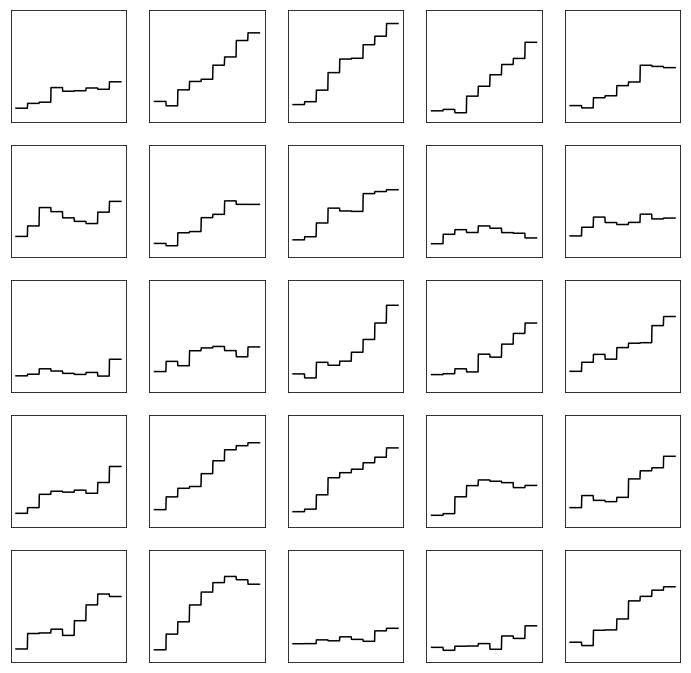

In [10]:
train_models_th, train_labels_th = sample_model_N_times(dVel0, dVel, v0, dv_l_const, v_max, n_layers, dz, dx, ny, nz, 100)

ax = plot_velocity_profile_grid(train_labels_th/v_max, nz)

As Roeth and Tarantola have mentioned, their generative model allows for the velocities to have a near linear increase with depth but also allow for random jumps to lower velocities.
In the next blog post - part 2 - we'll use a finite-difference forward model to generate synthetic acoustic waveforms. Stay tuned!

If you enjoyed this, or have critique, please feel free to comment on Twitter or raise an issue on github!